# Logistic Regression with Python

For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [3]:
train = pd.read_csv('titanic_train.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

## Missing Data

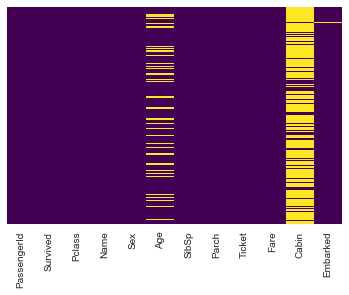

In [5]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


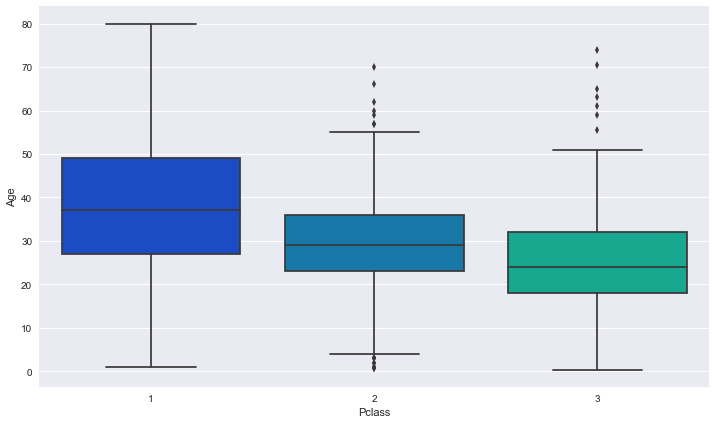

In [6]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [7]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [8]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Drop the Cabin data and the last single row 

In [9]:
train.drop('Cabin',axis=1,inplace=True)
train.dropna(inplace=True)

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables. Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

Transform the sex and embark variables to dummy variables. Drop the useless ML variables (Name, Ticket).

In [10]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [11]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [12]:
train = pd.concat([train,sex,embark],axis=1)

In [13]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


### Important note on multiple categorical features

What if you have categorical features?  For example, imagine there is data on the color of each
iris:

    color in [red, blue, purple]

You might be tempted to assign numbers to these features, i.e. *red=1, blue=2, purple=3*
but in general **this is a bad idea**.  Estimators tend to operate under the assumption that
numerical features lie on some continuous scale, so, for example, 1 and 2 are more alike
than 1 and 3, and this is often not the case for categorical features.

In fact, the example above is a subcategory of "categorical" features, namely, "nominal" features. Nominal features don't imply an order, whereas "ordinal" features are categorical features that do imply an order. An example of ordinal features would be T-shirt sizes, e.g., XL > L > M > S. 

One work-around for parsing nominal features into a format that prevents the classification algorithm from asserting an order is the so-called one-hot encoding representation. Here, we give each category its own dimension:

- color=purple (1.0 or 0.0)
- color=blue (1.0 or 0.0)
- color=red (1.0 or 0.0)

Note that using many of these categorical features may result in data which is better
represented as a **sparse matrix**, as we'll see with the text classification example
below.

In [1]:
measurements = [
    {'city': 'Dubai', 'temperature': 33.},
    {'city': 'London', 'temperature': 12.},
    {'city': 'San Francisco', 'temperature': 18.},
]

from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()
vec.fit_transform(measurements).toarray()
vec.get_feature_names()

['city=Dubai', 'city=London', 'city=San Francisco', 'temperature']

# Building a Logistic Regression model

## Train Test Split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X = train.drop('Survived',axis=1)
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
predictions = logmodel.predict(X_test)

## Evaluation

We can check precision,recall,f1-score using classification report!

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [20]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.81      0.93      0.86       163
          1       0.85      0.65      0.74       104

avg / total       0.82      0.82      0.81       267



In [21]:
confusion_matrix(y_test, predictions)

array([[151,  12],
       [ 36,  68]])